In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("giphy_with_descriptions.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10972 entries, 0 to 10971
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   GIF ID                10972 non-null  object
 1   Web Archive Link      10972 non-null  object
 2   MD5 Hash              10972 non-null  object
 3   File Size (In Bytes)  10972 non-null  int64 
 4   GIPHY Title           10461 non-null  object
 5   Import Date           10656 non-null  object
 6   Trending Date         10656 non-null  object
 7   Description           2463 non-null   object
dtypes: int64(1), object(7)
memory usage: 685.9+ KB


In [3]:
giphy_data = df[
    df['GIPHY Title'].notnull() &
    (df['GIPHY Title'] != '[empty]') &
    (df['GIPHY Title'] != 'NA')
]
giphy_data

giphy_data['GIPHY Title'] = giphy_data['GIPHY Title'].str.replace(r'\bGIF\b', '', regex=True).str.strip()

<ipython-input-3-34b33f9d1ad3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  giphy_data['GIPHY Title'] = giphy_data['GIPHY Title'].str.replace(r'\bGIF\b', '', regex=True).str.strip()


In [4]:
import spacy
from textblob import TextBlob
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# Define an enhanced preprocessing function
def preprocess_titles_enhanced(title):
    """
    Enhanced preprocessing for extracting sentiment and keywords from titles.
    """
    if pd.isna(title):
        return {"emotion": "unknown", "keywords": []}

    # Clean and tokenize the title using spaCy
    doc = nlp(title.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in ENGLISH_STOP_WORDS]

    # Extract sentiment polarity and categorize into emotions
    sentiment = TextBlob(title).sentiment.polarity
    if sentiment > 0.3:
        emotion = "positive"
    elif sentiment < -0.3:
        emotion = "negative"
    else:
        emotion = "neutral"

    # Extract keywords by filtering nouns and adjectives
    keywords = [token.text for token in doc if token.pos_ in {"NOUN", "ADJ"}]

    return {"emotion": emotion, "keywords": keywords}


giphy_data["processed"] = giphy_data["GIPHY Title"].apply(preprocess_titles_enhanced)

# Extract the processed information into separate columns for display
giphy_data["emotion"] = giphy_data["processed"].apply(lambda x: x["emotion"])
giphy_data["keywords"] = giphy_data["processed"].apply(lambda x: x["keywords"])

# Drop the intermediate 'Processed' column for clarity
dataset = giphy_data.drop(columns=['processed'])
dataset
dataset.to_csv("cleangiphy.csv")

<ipython-input-4-1e06c7cf623f>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  giphy_data["processed"] = giphy_data["GIPHY Title"].apply(preprocess_titles_enhanced)
<ipython-input-4-1e06c7cf623f>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  giphy_data["emotion"] = giphy_data["processed"].apply(lambda x: x["emotion"])
<ipython-input-4-1e06c7cf623f>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

# Prepare data for clustering
# Convert emotions to numerical labels
label_encoder = LabelEncoder()
emotion_labels = label_encoder.fit_transform(dataset['emotion'])

# Vectorize the keywords using TF-IDF
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
keywords_vectorized = vectorizer.fit_transform(dataset['keywords'].apply(lambda x: " ".join(x)))

# Combine emotion labels and TF-IDF vectors for clustering
from scipy.sparse import hstack
features = hstack([keywords_vectorized, emotion_labels.reshape(-1, 1)])

# Apply K-Means clustering
num_clusters = 5  # Set number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
dataset['Cluster'] = kmeans.fit_predict(features)

# Analyze cluster distribution
cluster_summary = dataset.groupby('Cluster').size()

cluster_summary


,0
Cluster,
0,82
1,9516
2,85
3,90
4,688


In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Function to process query
def process_query(query):
    # Use TextBlob for sentiment analysis to extract emotion from query
    sentiment = TextBlob(query).sentiment
    query_emotion = "positive" if sentiment.polarity > 0 else "negative" if sentiment.polarity < 0 else "neutral"

    # Vectorize the query keywords using the same vectorizer
    query_keywords_vector = vectorizer.transform([query])

    return query_emotion, query_keywords_vector

# Function to perform retrieval
def retrieve_gifs(query, top_n=10):
    # Process the query
    query_emotion, query_keywords_vector = process_query(query)

    # Match clusters by emotion similarity
    matching_clusters = dataset[dataset['emotion'] == query_emotion]

    if matching_clusters.empty:
        return "No matching clusters found for the specified emotion."

    # Compute cosine similarity for keywords within the matching clusters
    matching_keywords_vectors = vectorizer.transform(
        matching_clusters['keywords'].apply(lambda x: " ".join(x))
    )
    similarity_scores = cosine_similarity(query_keywords_vector, matching_keywords_vectors).flatten()

    # Add similarity scores to the dataset
    matching_clusters = matching_clusters.copy()
    matching_clusters['Similarity'] = similarity_scores

    # Rank by similarity score and select top N results
    top_results = matching_clusters.nlargest(top_n, 'Similarity')
    return top_results[['GIF ID', 'Web Archive Link', 'GIPHY Title', 'emotion', 'Similarity']]

# Example Query
query_example = "Confident"

results = retrieve_gifs(query_example)
results

,GIF ID,Web Archive Link,GIPHY Title,emotion,Similarity
3,1003Kuq13ICXDO,http://webarchive.loc.gov/all/20150318155641/h...,love happy,positive,0.0
8,100afL9qoUSWSQ,http://webarchive.loc.gov/all/20150318155641/h...,happy new england patriots,positive,0.0
10,100buaImlNtEuk,http://webarchive.loc.gov/all/20150318155641/h...,absolutely fabulous,positive,0.0
58,103c3dyvMqv624,http://webarchive.loc.gov/all/20150318155641/h...,the good dinosaur by Disney Pixar,positive,0.0
62,103JnbaqvpBFGE,http://webarchive.loc.gov/all/20150318155641/h...,excited tiger,positive,0.0
67,103wxMOQYiCOjK,http://webarchive.loc.gov/all/20150318155641/h...,happy sun,positive,0.0
114,107nbr93ZhiUJq,http://webarchive.loc.gov/all/20150318155641/h...,cute puppy,positive,0.0
116,107w1QelN7fTcA,http://webarchive.loc.gov/all/20150318155641/h...,unique maggie gyllenhaal,positive,0.0
126,108M7gCS1JSoO4,http://webarchive.loc.gov/all/20150318155641/h...,valentines day love,positive,0.0
128,108OKB1XHmqUI8,http://webarchive.loc.gov/all/20150318155641/h...,i love lucy,positive,0.0


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
import numpy as np

# Fill missing values in titles and descriptions with empty strings
dataset['GIPHY Title'] = dataset['GIPHY Title'].fillna('')
dataset['Description'] = dataset['Description'].fillna('')

# Combine keywords, titles, and descriptions into a single text field for vectorization
dataset['combined_text'] = dataset.apply(
    lambda row: ' '.join(row['keywords']).replace("'", "").replace("[", "").replace("]", "") +
                ' ' + row['GIPHY Title'] + ' ' + row['Description'],
    axis=1
)

# Vectorize the combined text using TF-IDF
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
combined_vectorized = vectorizer.fit_transform(dataset['combined_text'])

print(f"Dataset Index: {dataset.index}")  # Indices of the dataset
print(f"Combined Vectorized Shape: {combined_vectorized.shape[0]}")  # Number of rows in the sparse matrix
# Function to process query with sentiment analysis and vectorization
def process_query(query):
    # Use TextBlob for sentiment analysis to extract emotion from query
    sentiment = TextBlob(query).sentiment
    query_emotion = "positive" if sentiment.polarity > 0 else "negative" if sentiment.polarity < 0 else "neutral"

    # Vectorize the query text
    query_vector = vectorizer.transform([query])

    return query_emotion, query_vector

# Function to perform retrieval based on combined text similarity
def retrieve_gifs_fixed(query, top_n=10):
    # Process the query
    query_emotion, query_vector = process_query(query)

    # Filter dataset by matching emotions
    matching_gifs = dataset[dataset['emotion'] == query_emotion].reset_index(drop=True)

    if matching_gifs.empty:
        return "No matching GIFs found for the specified emotion."

    # Select rows from the sparse matrix corresponding to the filtered dataset
    matching_indices = matching_gifs.index.to_numpy()
    matching_vectors = combined_vectorized[matching_indices]

    # Compute cosine similarity with the combined text
    similarity_scores = cosine_similarity(query_vector, matching_vectors).flatten()

    # Add similarity scores to the filtered dataset
    matching_gifs = matching_gifs.copy()
    matching_gifs['Similarity'] = similarity_scores

    # Rank by similarity score and select top N results
    top_results = matching_gifs.nlargest(top_n, 'Similarity')
    return top_results[['GIF ID', 'Web Archive Link', 'GIPHY Title', 'Description', 'emotion', 'Similarity']]

# Example Query
query_example = "A happy moment with a cat"

# Retrieve GIFs for the query
results = retrieve_gifs(query_example)

results


Dataset Index: Index([    0,     1,     2,     3,     4,     5,     7,     8,     9,    10,
       ...
       10962, 10963, 10964, 10965, 10966, 10967, 10968, 10969, 10970, 10971],
      dtype='int64', length=10461)
Combined Vectorized Shape: 10461


,GIF ID,Web Archive Link,GIPHY Title,emotion,Similarity
6783,2QHLYZFJgjsFq,http://webarchive.loc.gov/all/20150318155641/h...,happy cat,positive,1.000000
7129,33OrjzUFwkwEg,http://webarchive.loc.gov/all/20150318155641/h...,happy cat,positive,1.000000
7279,3C7wcZZWGf2Cs,http://webarchive.loc.gov/all/20150318155641/h...,happy cat,positive,1.000000
1841,124if4JhjDwGHu,http://webarchive.loc.gov/all/20150318155641/h...,happy birthday cat,positive,0.723354
4000,1DTBGm5Rfgymk,http://webarchive.loc.gov/all/20150318155641/h...,happy birthday cat,positive,0.723354
6013,26tPgbUUcfS5IWiTm,http://webarchive.loc.gov/all/20150318155641/h...,machines of loving grace cat by Faith Holland,positive,0.715793
3,1003Kuq13ICXDO,http://webarchive.loc.gov/all/20150318155641/h...,love happy,positive,0.698312
8,100afL9qoUSWSQ,http://webarchive.loc.gov/all/20150318155641/h...,happy new england patriots,positive,0.698312
67,103wxMOQYiCOjK,http://webarchive.loc.gov/all/20150318155641/h...,happy sun,positive,0.698312
150,10aADbYxnJlc9q,http://webarchive.loc.gov/all/20150318155641/h...,happy global warming,positive,0.698312


In [8]:
annotated_queries = pd.read_csv("annotated_queries.csv")
annotated_queries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Query      150 non-null    object
 1   GIF ID     150 non-null    object
 2   Relevance  150 non-null    object
dtypes: object(3)
memory usage: 3.6+ KB


In [9]:
relevance_map = {"Highly Relevant": 2, "Moderately Relevant": 1, "Not Relevant": 0}
annotated_queries['Relevance'] = annotated_queries['Relevance'].map(relevance_map)

In [10]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate_model(annotated_queries, top_n=10):
    precision_list = []
    recall_list = []
    f1_list = []

    for _, row in annotated_queries.iterrows():
        query = row['Query']
        relevant_gif_id = row['GIF ID']
        relevance_score = row['Relevance']

        # Retrieve top N GIFs for the query
        retrieved_gifs = retrieve_gifs_fixed(query, top_n)

        # Check if the relevant GIF is in the top N
        retrieved_ids = retrieved_gifs['GIF ID'].tolist()
        is_relevant = [1 if gif_id == relevant_gif_id else 0 for gif_id in retrieved_ids]
        true_labels = [1 if relevance_score > 0 else 0] * len(is_relevant)

        # Calculate precision, recall, and F1 for this query
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, is_relevant, average='binary', zero_division=0
        )

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    # Compute average precision, recall, and F1 scores
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)


    return avg_precision, avg_recall, avg_f1


In [21]:
precision, recall, f1 = evaluate_model(annotated_queries)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.0200
Recall: 0.0020
F1 Score: 0.0036


In [12]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate_model_old(annotated_queries, top_n=10):
    precision_list = []
    recall_list = []
    f1_list = []

    for _, row in annotated_queries.iterrows():
        query = row['Query']
        relevant_gif_id = row['GIF ID']
        relevance_score = row['Relevance']

        # Retrieve top N GIFs for the query
        retrieved_gifs = retrieve_gifs(query, top_n)

        # Check if the relevant GIF is in the top N
        retrieved_ids = retrieved_gifs['GIF ID'].tolist()
        is_relevant = [1 if gif_id == relevant_gif_id else 0 for gif_id in retrieved_ids]
        true_labels = [1 if relevance_score > 0 else 0] * len(is_relevant)

        # Calculate precision, recall, and F1 for this query
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, is_relevant, average='binary', zero_division=0
        )

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    # Compute average precision, recall, and F1 scores
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)

    return avg_precision, avg_recall, avg_f1

In [22]:
precision_old, recall_old, f1_old = evaluate_model_old(annotated_queries)
print(f"Precision: {precision_old:.4f}")
print(f"Recall: {recall_old:.4f}")
print(f"F1 Score: {f1_old:.4f}")

Precision: 0.1267
Recall: 0.0127
F1 Score: 0.0230


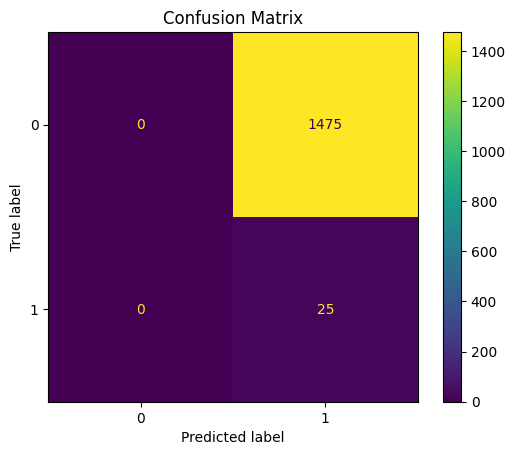

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Assuming binary relevance (relevant vs. not relevant)
y_true = []
y_pred = []

for _, row in annotated_queries.iterrows():
    query = row['Query']
    relevant_gifs = set(row['GIF ID'].split(','))
    top_results = retrieve_gifs(query, top_n=10)['GIF ID']
    y_true.append([1 if gif_id in relevant_gifs else 0 for gif_id in top_results])
    y_pred.append([1] * len(top_results))  # Predict all top-N as relevant

y_true_flat = np.concatenate(y_true)
y_pred_flat = np.concatenate(y_pred)

ConfusionMatrixDisplay.from_predictions(y_true_flat, y_pred_flat)
plt.title("Confusion Matrix")
plt.show()


<ipython-input-15-9d0e493149e1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataset, x='Cluster', palette='viridis')


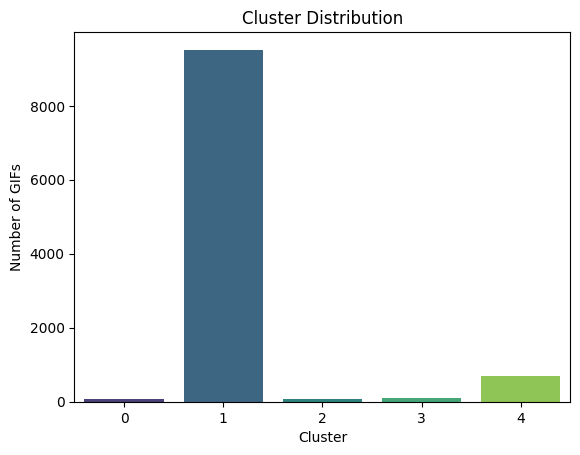

In [15]:
import seaborn as sns

sns.countplot(data=dataset, x='Cluster', palette='viridis')
plt.title("Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of GIFs")
plt.show()

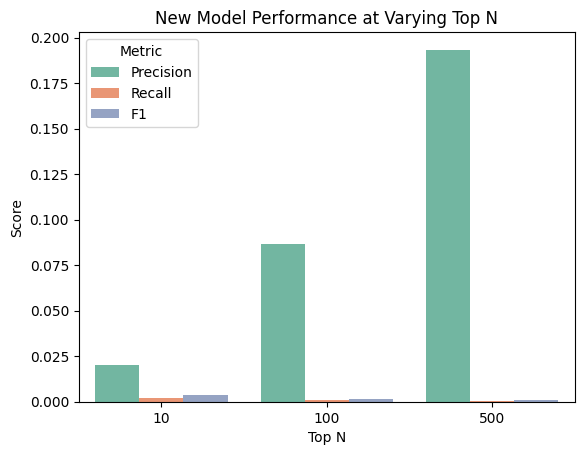

In [18]:
top_n_values = [10, 100, 500]
scores = {'Top N': [], 'Precision': [], 'Recall': [], 'F1': []}

for top_n in top_n_values:
    precision, recall, f1 = evaluate_model(annotated_queries, top_n=top_n)
    scores['Top N'].append(top_n)
    scores['Precision'].append(precision)
    scores['Recall'].append(recall)
    scores['F1'].append(f1)

scores_df = pd.DataFrame(scores)

sns.barplot(data=scores_df.melt(id_vars=['Top N'], var_name='Metric'), x='Top N', y='value', hue='Metric', palette='Set2')
plt.title("New Model Performance at Varying Top N")
plt.xlabel("Top N")
plt.ylabel("Score")
plt.show()


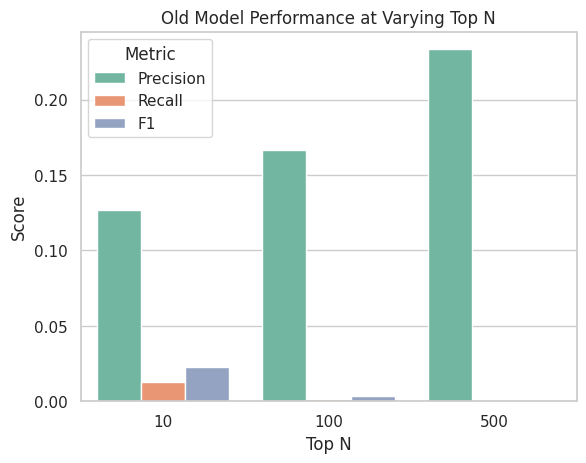

In [20]:
top_n_values_old = [10, 100, 500]
scores_old = {'Top N': [], 'Precision': [], 'Recall': [], 'F1': []}

for top_n in top_n_values_old:
    precision_old, recall_old, f1_old = evaluate_model_old(annotated_queries, top_n=top_n)
    scores_old['Top N'].append(top_n)
    scores_old['Precision'].append(precision_old)
    scores_old['Recall'].append(recall_old)
    scores_old['F1'].append(f1_old)

scores_df_old = pd.DataFrame(scores_old)

sns.barplot(data=scores_df_old.melt(id_vars=['Top N'], var_name='Metric'), x='Top N', y='value', hue='Metric', palette='Set2')
plt.title("Old Model Performance at Varying Top N")
plt.xlabel("Top N")
plt.ylabel("Score")
plt.show()
